# Introdução às Redes Neurais Fisicamente Informadas (Material Extra) Picture1.jpg

---
### Exemplo 12

**Objetivo:** Neste notebook o objetivo é estimar os coeficientes de um sistema de EDOs de forma que a variável dependente $y_1(t)$ deve se comportar semelhante à uma lista de pontos fornecidos $\{(t_0,y_1(t_0)),(t_1,y_1(t_1)),\ldots,(t_m,y_1(t_m))\}$. Neste caso, temos um problema inverso de estimação de parâmetros.

Para tal consideramos o sistema
$$ \frac{dy_1}{dt}=-A_1 y_1 + B_1 y_2 + C_1\left[ H(t-E_1)-H(t-F_1) \right] - D_1 y_1 y_2 \\
\frac{dy_2}{dt}=A_1 y_1 - B_1 y_2 + D_1 y_1 y_2,
$$
sendo que $A_1,\ldots,F_1$ são os parâmetros a serem calculados pela rede.  Aqui as condições iniciais desse sistema de primeira ordem são: $y_1(0)=y_2(0)=0.$

A estimação é baseada no fato que os coeficientes serão também parâmetros treináveis pela rede e a função de perda será modificada para incluir uma comparação que envolva o conjunto de pontos fornecidos com a solução calculada pela rede.

Neste caso a perda terá a forma
$$\text{Loss}=\lambda_1\mathcal{L}_1+\lambda_2\mathcal{L}_2+\lambda_3\mathcal{L}_{ic1}+\lambda_4\mathcal{L}_{ic2}+\lambda_5\mathcal{L}_{\text{ext_data}},$$
em que $\lambda_i$ são pesos que podem ser atribuídos para dar mais importância a uma parcela da função de perda e $\mathcal{L}_{\text{ext_data}}$ é a nova parte da perda que servirá para comparar os dados externos com o modelo dado pela equação diferencial. O novo termo na função de perda será, para este caso, dado na forma:
$$\mathcal{L}_{\text{ext_data}}=\frac{1}{M}\sum_i \left( \text{NN}_1(t_i)-y_i \right)^2,$$
sendo que $\text{NN}_1$ é a componente $y_1(t)$ aproximada pela rede e $(t_i,y_i)$ os pontos conhecidos que foram fornecidos. *Obs.: os demais quatro termos da função de perda correspondem as perdas das duas equações e das duas condições iniciais.*

---
Instalando o DeepXDE

In [14]:
# carrega o deepxde
!pip install deepxde -q gwpy

---
Importa as coisas necessárias

*Obs.: usando o backend `pytorch` para evitar o bug do L-BFGS.*

In [15]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import deepxde as dde
dde.config.set_default_float('float64')
import numpy as np
import torch

Set the default float type to float64


---
Criamos aqui um conjunto de observações que serão utilizadas para encontrar o sistema de EDOs que melhor se adequa à elas. Isto é, queremos encontrar os parâmetros do sistema de tal forma que a curva gerada pela EDO esteja, sobre alguma métrica, o mais próximo possível dos pontos fornecidos. Essa métrica é consolidada na função de perda, como será discutido adiante.

In [16]:
# Dados observados
ob_t0 = [11.97, 13.98, 16.09, 17.95, 19.90, 21.85, 23.89, 25.85, 27.65, 29.98, 31.97, 33.96, 35.94, 38.01, 40.07, 41.87, 43.93, 45.98, 48.13, 50.18, 51.98, 54.12, 56.18, 58.06, 60.03]
ob_y0 = [0.00, 93.31, 166.33, 230.43, 280.73, 328.60, 355.38, 374.04, 369.17, 329.41, 272.62, 225.56, 193.10, 175.25, 164.71, 159.03, 148.48, 141.99, 137.93, 132.25, 128.19, 124.95, 122.52, 123.33, 120.08 ]

# Normalização dos dados observados
ob_t = (np.array(ob_t0)-(max(ob_t0)-60))/(max(ob_t0)-(max(ob_t0)-60))
ob_y = (np.array(ob_y0)-min(ob_y0))/(max(ob_y0)-min(ob_y0))

# Ajuste do vetor para ser utilizado pelas funções de perda adiante
ob_t = ob_t.reshape((len(ob_t0), 1))
ob_y = ob_y.reshape((len(ob_t0), 1))


---
O modelo que se deseja encontrar os parâmetros é o sistema de EDOs
$$ \frac{dy_1}{dt}=-A_1 y_1 + B_1 y_2 + C_1\left[ H(t-E_1)-H(t-F_1) \right] - D_1 y_1 y_2 \\
\frac{dy_2}{dt}=A_1 y_1 - B_1 y_2 + D_1 y_1 y_2,
$$
em que $H(t)$ é a função degrau unitário de Heaviside. Os parâmetros que se deseja calcular são os coeficientes $A_1,B_1,\ldots,F_1$.

Esses coeficientes precisam receber um valor inicial, que será atualizado junto com os pesos e viéses do sistema. Essa atribuição é feita com o comando `dde.Variable('valorinicialdavariavel')`.

*Obs.: Na prática, abaixo no código vocês irão perceber a função de Heaviside não está sendo utilizada e sim uma aproximação contínua dela utilizando uma diferença de sigmóides. Isto está sendo feito pois ao utilizar a função de Heaviside implementada no `pytorch` uma mensagem de erro é retornada, e o código interrompido, informando que a derivada da função de Heaviside não está implementada.*

In [17]:
A1 = dde.Variable(1.0)
B1 = dde.Variable(1.0)
C1 = dde.Variable(1.0)
D1 = dde.Variable(1.0)
E1 = dde.Variable(0.5)
F1 = dde.Variable(0.0)

def ode_nl1(x, y):
    y1, y2 = y[:, 0:1], y[:, 1:2]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [
        dy1_x + A1*y1 - B1*y2 - C1*(1/(1+torch.exp(-30*(x-E1)))-1/(1+torch.exp(-30*(x-F1)))) + D1*y1*y2,
        dy2_x - A1*y1 + B1*y2 - D1*y1*y2,
    ]

---
Agora definimos o domínio e as condições iniciais. O domínio é o intervalo $[0,1]$ e as condições iniciais são $y_1(0)=y_2(0)=0.$

Aqui a parte mais importante é a forma que vamos incluir os pontos conhecidos para fazermos a estimação de parâmetros. Na prática, queremos incluir um termo na função de perda que compara a função dada pela rede neural com os pontos que foram fornecidos inicialmente. Isto é, iremos incluir um novo termo na função de perda que é:
$$\mathcal{L}_{\text{ext_data}}=\frac{1}{M}\sum_i \left( \text{NN}_1(t_i)-y_i \right)^2,$$
sendo que $\text{NN}_1$ é a componente $y_1(t)$ aproximada pela rede e $(t_i,y_i)$ os pontos conhecidos que foram fornecidos. Isto é feito utilizando o comando `dde.icbc.PointSetBC(ob_t, ob_y, component=0)` que irá gerar o novo termo da função de perda comparando o $y_1(t)$ estimado pela rede com os dados no vetor `ob_y`.



In [18]:
def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(ob_t[0][0], 1)

# CONDIÇÕES INICIAIS
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)

# INSERE O CONJUNTO DE DADOS CONHECIDOS NA FUNÇÃO DE PERDA
observe_y0 = dde.icbc.PointSetBC(ob_t, ob_y, component=0)

---
Monta a estrutura da rede neural. Até agora tudo semelhante ao que já fizemos antes. Observe que junto das condições iniciais estamos incluindo a parte da função de perda que corresponde à comparação desejada. Lembre-se de que `ic1`, `ic2` e `observe_y0` são todas funções de perda.

In [19]:
dde.config.set_random_seed(1)

# Gera os dados de treino para o sistema de EDO, condições iniciais e domínio
data1 = dde.data.PDE(
    geom,
    ode_nl1,
    [ic1, ic2, observe_y0],
    num_domain=1000,
    num_boundary=2,
    anchors=ob_t,
)

# Monta a estrutura da rede
net1 = dde.nn.FNN([1] + [100] * 4 + [2], "tanh", "Glorot uniform")
model1 = dde.Model(data1, net1)

---
Precisamos informar para o otimizador que além das variáveis usuais da rede neural (os pesos e viéses) iremos incluir outras variáveis treináveis. Estamos fazendo aqui utilizando o vetor `etv = [A1, B1, C1, D1, E1, F1]`. Esse vetor precisará ser passado pelo compilador da rede. Como aqui estamos usando o `adam` e o `L-BFGS`, precisamos passar o vetor de parâmetros treináveis para os dois processos de treinamento incluindo, em cada uma dela, a referência `external_trainable_variables=etv`.

Como podemos visualizar os parâmetros calculados? Neste caso estamos salvando eles a cada 500 épocas no arquivo `variables_nl1.dat`. Esse arquivo pode ser acessado e conterá a evolução dos coeficientes calculados até o final do processo iterativo.

Finalmente, o processo de treinamento é baseado na minimização de uma função de perda que neste caso tem a forma
$$\text{Loss}=\lambda_1\mathcal{L}_1+\lambda_2\mathcal{L}_2+\lambda_3\mathcal{L}_{ic1}+\lambda_4\mathcal{L}_{ic2}+\lambda_5\mathcal{L}_{\text{ext_data}},$$
em que $\lambda_i$ são pesos que podem ser atribuídos para dar mais importância a uma parcela da função de perda. O padrão, quando essa informação não é fornecida, é que todos os pesos são iguais e unitários ($\lambda_i=1,$ para todo $i$). Caso deseje modificar a atribuição desses pesos, então deve ser incluído na compilação do otimizador os pesos desejados passando o parâmetro `loss_weights = [l1,l2,l3,l4,l5]'. Neste nosso exemplo temos efetivamente cinco parcelas na perda, duas pras equações, duas pras condições iniciais e uma de comparação com os dados externos.

Agora é só colocar pra treinar.

Compiling model...
'compile' took 0.001100 s

Training model...

0         [2.79e-01, 2.35e-02, 3.83e-04, 7.67e-04, 4.00e-01]    [2.79e-01, 2.35e-02, 3.83e-04, 7.67e-04, 4.00e-01]    []  
1000      [6.86e-03, 2.61e-04, 2.21e-02, 6.64e-04, 8.92e-02]    [6.86e-03, 2.61e-04, 2.21e-02, 6.64e-04, 8.92e-02]    []  
2000      [1.98e-03, 3.86e-05, 1.26e-02, 1.39e-04, 7.67e-02]    [1.98e-03, 3.86e-05, 1.26e-02, 1.39e-04, 7.67e-02]    []  
3000      [1.43e-03, 2.53e-05, 8.13e-03, 2.40e-05, 6.39e-02]    [1.43e-03, 2.53e-05, 8.13e-03, 2.40e-05, 6.39e-02]    []  
4000      [1.01e-03, 1.47e-05, 5.76e-03, 3.46e-05, 4.71e-02]    [1.01e-03, 1.47e-05, 5.76e-03, 3.46e-05, 4.71e-02]    []  
5000      [6.37e-04, 2.29e-05, 3.88e-03, 3.17e-05, 3.11e-02]    [6.37e-04, 2.29e-05, 3.88e-03, 3.17e-05, 3.11e-02]    []  
6000      [3.71e-04, 2.43e-05, 2.30e-03, 1.34e-05, 2.13e-02]    [3.71e-04, 2.43e-05, 2.30e-03, 1.34e-05, 2.13e-02]    []  
7000      [2.30e-04, 2.16e-05, 1.32e-03, 8.68e-06, 1.55e-02]    [2.30e-04,

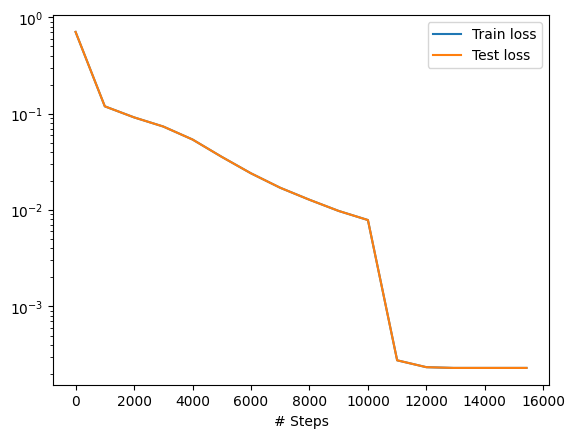

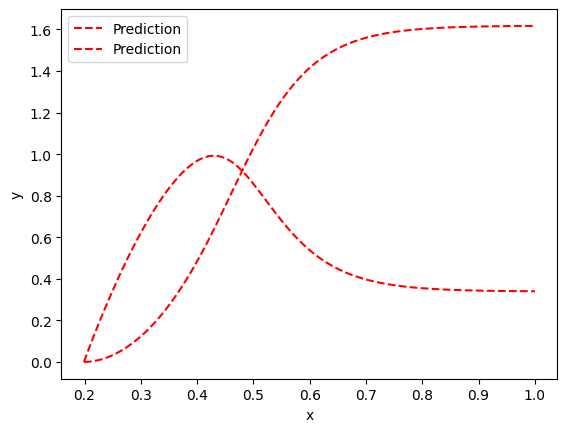

In [20]:
etv = [A1, B1, C1, D1, E1, F1]
variable1 = dde.callbacks.VariableValue(etv, period=500, filename="variables_nl1.dat")

# Compila com o otimizador ADAM
model1.compile(
    "adam", lr=0.001, external_trainable_variables=etv, loss_weights = [1,1,1,1,1]
)

# Faz a primeira sessão de treinamento
losshistory1, train_state1 = model1.train(iterations=10000, callbacks=[variable1])


# Compila com o otimizador L-BFGS
dde.optimizers.config.set_LBFGS_options(maxiter=5000) # limita o número máximo de iterações pra 5000
model1.compile("L-BFGS", external_trainable_variables=etv, loss_weights = [1,1,1,1,1])

# Faz a segunda sessão de treinamento com o
losshistory1, train_state1 = model1.train(callbacks=[variable1])

dde.saveplot(losshistory1, train_state1, issave=False, isplot=True)

---
Depois de treinado vamos ver se a rede consegui se adaptar aos pontos fornecidos.

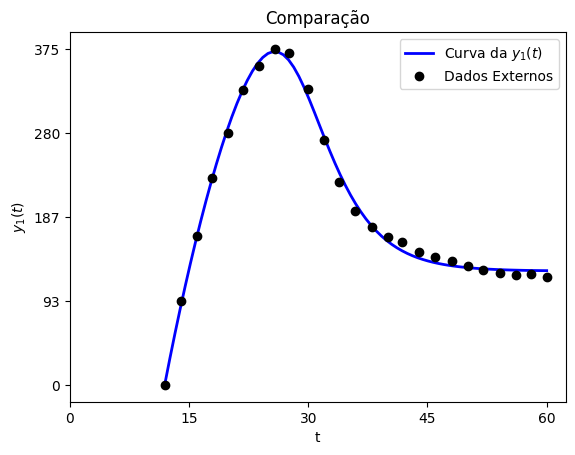

In [24]:
import matplotlib.pyplot as plt
import math

t = np.linspace(ob_t[0][0], 1, 75)

t = t.reshape(75, 1)

yhat1 = model1.predict(t)

plt.title("Comparação")
plt.plot(t, yhat1[:,0:1], "b-", label="Curva da $y_1(t)$",linewidth=2.0)
plt.plot(ob_t, ob_y, "ko", label="Dados Externos")
plt.legend(loc="upper right")
plt.xlabel("t")
plt.ylabel("$y_1(t)$")
plt.xticks([0.00,0.25,0.50,0.75,1.00], [0, 15, 30, 45, 60])
plt.yticks([0.00,0.25,0.50,0.75,1.00], [0, math.floor(max(ob_y0)/4), math.floor(max(ob_y0)/2), math.floor(3*max(ob_y0)/4), math.ceil(max(ob_y0))])
plt.show()


---
Finalmente, caso queria ver o valor das variáveis basta imprimí-los.

In [30]:
print(A1.detach().cpu().numpy())
print(B1.detach().cpu().numpy())
print(C1.detach().cpu().numpy())
print(D1.detach().cpu().numpy())
print(E1.detach().cpu().numpy())
print(F1.detach().cpu().numpy())

3.6832747421644556
2.618053876349975
7.396197780805774
5.446726311709521
0.019439173019899034
0.4637475755231577
